# Artur`s part


In [1]:
import math
import numpy as np 
import scipy.integrate as integrate
import scipy.special as special
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from tqdm import tqdm

### В качестве ортнормированного базиса в $L^2[0, T]$ была выбрана система функций $\phi_{k}(x) = \sqrt{\frac{2}{T}}sink\frac{\pi}{T}x$, $k = 1, 2, ...$
### $\int_{0}^t\sqrt{\frac{2}{T}}sink\frac{\pi}{T}x = \frac { \sqrt{\frac{2}{T}}T(1-cos \frac{\pi k t}{T})}{\pi k}$


In [2]:
def phi(x, k, T = 1):
    #Сама функция \phi 
    return math.sqrt(2/T) * math.sin( k * (math.pi/T) * x)

def integral_of_phi(t, num_samples = 100000, T = 1, analytical = True):
    # Вычисление интеграла от функции. Можно посчитать приблизительно или с помощью формулы аналитически
    if t > T:
        raise Exception('ERROR: t > T' )
    
    vec = []
    for i in range(1, num_samples+1):
        if not analytical:
            integr = integrate.quad(lambda s: phi(s, i), 0, t, epsabs= 1e-4)[0]
        else:
            integr = (math.sqrt(2/T) * T * (1 - math.cos(math.pi * i * t / T))/(math.pi * i))
            
        if abs(integr) > math.sqrt(2):
            integr = vec[-1]
        vec.append(integr)
    return np.array(vec)

In [3]:
def make_Wiener_simulation(T = 1,   num_samples = 300, 
                           mean = 0, std = 1, step= 0.0001, rnd = 32, analytical=True):
    #Симуляция по пункту А     
    Wiener_process = []
    np.random.seed(rnd)
    samples_of_noise = np.random.normal(mean, std, size=num_samples)

    num= int(T/step) 
    time = np.arange(0,num)*step

    for t in time:
        Wiener_process.append(
            np.sum(samples_of_noise * integral_of_phi(t, num_samples = num_samples, analytical=analytical))
        )
    return Wiener_process


### Одна и та же траектория для разных порядков приближения

<Axes: >

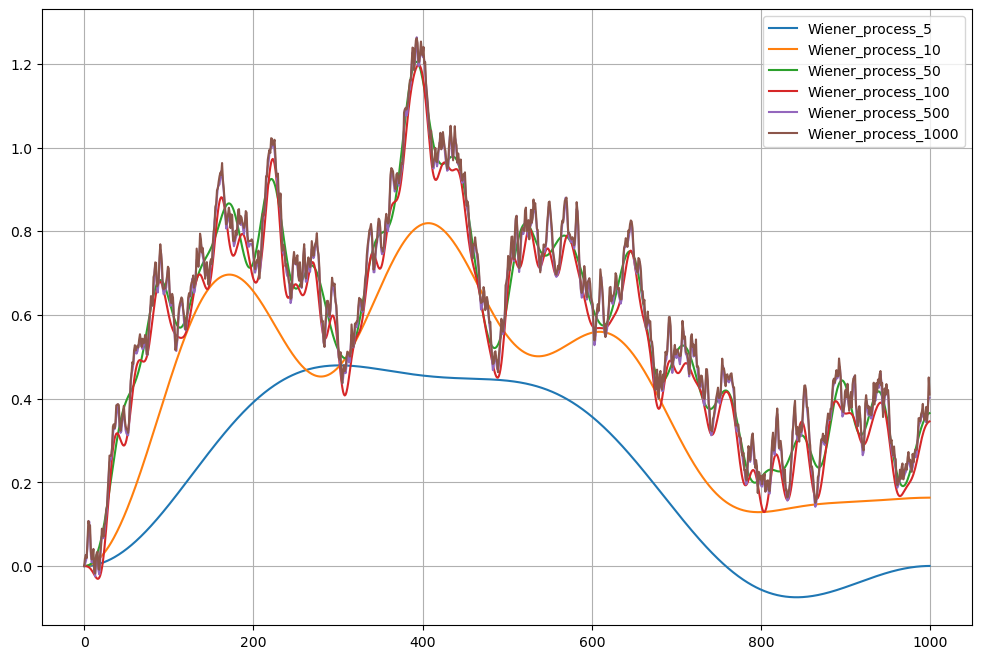

In [4]:
df = pd.DataFrame()
for i in [5, 10, 50, 100, 500, 1000]:
    df['Wiener_process_' + str(i)] = make_Wiener_simulation(num_samples = i)
df.to_csv('simulation_1.csv')
df.plot(grid= True, figsize= (12, 8))

### Разные сиды с одинаковым порядком приближения

<Axes: >

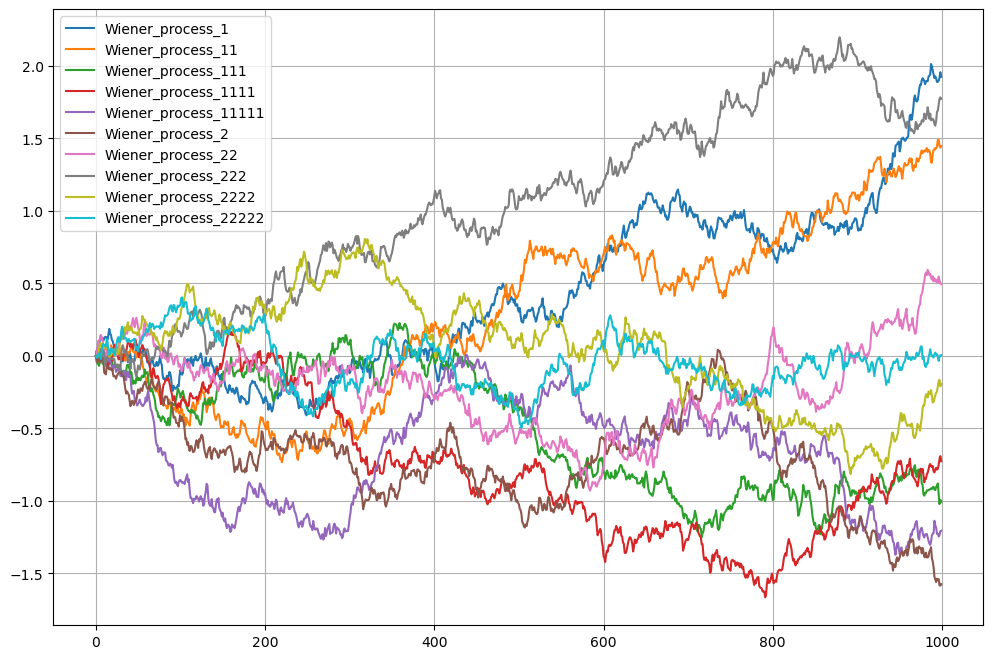

In [5]:
df = pd.DataFrame()
for i in [1, 11, 111, 1111, 11111, 2, 22, 222, 2222, 22222]:
    df['Wiener_process_' + str(i)] = make_Wiener_simulation(rnd = i, num_samples= 1000)
df.to_csv('simulation_2.csv')
df.plot(grid= True, figsize= (12, 8))

# Andrey`s part

## Задача 2.4


Проверим выполнение свойства 13 винеровского процесса

Пусть есть двоичное разбиение отрезка $[0, 1]$: $t_m^n = m \cdot 2^{-n}$, $m = 0,1,2... 2^{n} $

Тогда
$S_n = \sum_{m=0}^{2^n - 1} (w(t_{m+1}^n) - w(t_{m}^n))^2 \rightarrow t $ п.н.  при $n \rightarrow \inf$

In [52]:
def square_sum(order = 10):
    summ = np.sum(np.diff(make_Wiener_simulation(T=1, step = 2.0**(-order), rnd=42))**2)
    return summ

In [5]:
%%time
for n in [10]:
    print(f"order = {n}\t Sn = {square_sum(order = n)}")

order = 10	 Sn = 0.2685983468955305
CPU times: total: 391 ms
Wall time: 394 ms


К сожалению, наивная реализация с использованием готовой симуляции винеровского процесса через представление процесса в через ОНБ работает слишком долго по времени - 0.8 секунды для 10ого порядка, для вычисления порядка 20 потребуется примерно в $2^{10}$ раза больше времени/ресурсов - больше 12 минут 

### Реализация винеровского процесса, через уточнение на каждом интервале

Поэтому воспользуемся другим способом моделирования стандартного винеровского процесса:

$w(t) = \mu(t) + \sigma(t) \cdot X$, где $X$ - имеет стандартное нормальное распределение, не зависящая от w

$\mu(t) = \frac{(b-t)w(a) + (t-a)w(b)}{b-a}$

$\sigma^2 (t) = \frac{(b-t)(t-a)}{b-a}$

In [5]:
def make_Wiener_simulation_ab(a, b, wa, wb, mean = 0, std = 1, newstep = 0.001, rnd = 42):
    if a >= b:
        raise Exception('ERROR: a >= b' )
    np.random.seed(rnd)
    
    
    mu = lambda t: ((b-t)*wa+(t-a)*wb)/(b-a)
    sigma = lambda t: ((b-t)*(t-a)/(b-a))
    
    num = int((b-a)/newstep)
    time = np.linspace(start=a, stop=b, num=num)
    
    X = np.random.normal(0, 1, size=num)
    return mu(time) + sigma(time) * X


In [6]:
def make_Wiener_simulation_comb(T = 1,   num_samples = 300, 
                           mean = 0, std = 1, step1 = 0.001, step = 0.0001, rnd = 42):
    ''' making Wiener process by combination of method based on orthonormal basis and 
    filling in each segment  
    step1 - step for orthonormal basis, best - greater than 2**10
    step - total step of all resulted simulation
    '''
    Wiener_process_base = make_Wiener_simulation(T=T,mean = mean, std = std, step = step1, rnd = rnd, analytical=False)
    time_base = np.linspace(start=0, stop=T, num=int(T/step1))
    Wiener_process = []
    if step1 == step:
        return np.array(Wiener_process_base)
    for i in tqdm(range(len(Wiener_process_base) - 1)):
        Wiener_process.append(
            make_Wiener_simulation_ab(a = time_base[i], b = time_base[i+1],
                                      wa = Wiener_process_base[i], wb = Wiener_process_base[i+1],
                                     mean = mean, std = std, newstep = step, rnd = rnd))
    return np.array(Wiener_process).ravel()

Посмотрим на уже знакомые нам, но уточнённые траектории

100%|██████████| 999/999 [00:00<00:00, 23834.25it/s]


<Axes: >

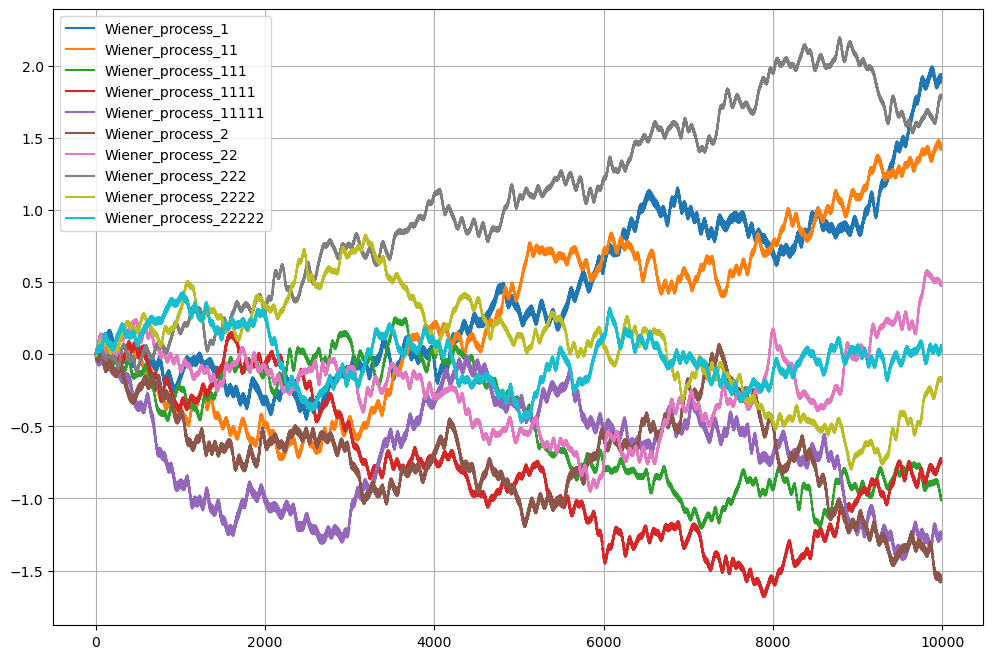

In [14]:
df = pd.DataFrame()
for i in [1, 11, 111, 1111, 11111, 2, 22, 222, 2222, 22222]:
    df['Wiener_process_' + str(i)] = make_Wiener_simulation_comb(rnd = i, num_samples= 1000)
df.to_csv('simulation_3.csv')
df.plot(grid= True, figsize= (12, 8))

In [49]:
def square_sum_comb(order = 10, rnd = 42, std = 1):
    np.random.seed(rnd)
    step = 2.0**(-order)
    step1 = 2.0**(-10) if order>10 else step
    
    Winier_process = make_Wiener_simulation_comb(T = 1, mean = 0, std = 1, step1 = step1, step = step, rnd = rnd)
    
    #print(f'len of Winier process = {len(Winier_process)}')
    #print(f'max diff in Winier process = {np.max(np.abs(np.diff(Winier_process)))}')
    summ = np.sum(np.diff(Winier_process)**2)
    return summ

In [106]:
%%time
square_sum_comb(order = 9)

<ipython-input-2-09fd761e572f>:13: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  integr = integrate.quad(lambda s: phi(s, i), 0, t, epsabs= 1e-4)[0]
<ipython-input-2-09fd761e572f>:13: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  integr = integrate.quad(lambda s: phi(s, i), 0, t, epsabs= 1e-4)[0]


Wall time: 2min 5s


1.0460687725615379

Наш функционал позволяет использовать формулу для построения реализации винеровского процесса на больших интервалах

<Axes: >

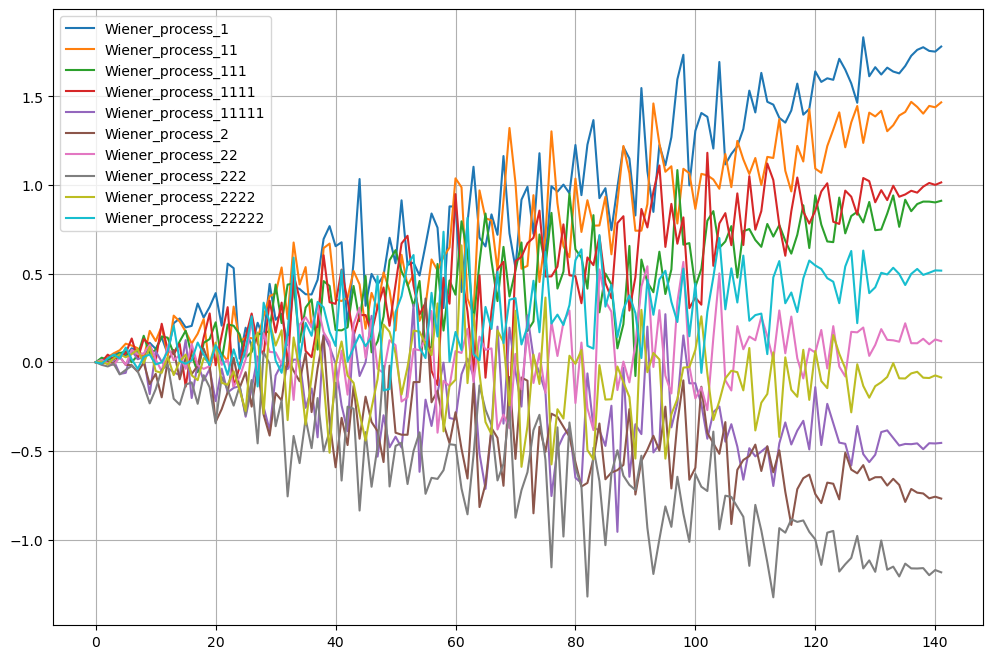

In [22]:
df = pd.DataFrame()
for i in [1, 11, 111, 1111, 11111, 2, 22, 222, 2222, 22222]:
    df['Wiener_process_' + str(i)] =  make_Wiener_simulation_ab(0,1,0, np.random.normal(0, 1, size=1),newstep=0.007)
df.to_csv('simulation_4.csv')
df.plot(grid= True, figsize= (12, 8))

К сожалению, в полученных траекториях явно виден тренд, что противоречит свойству винеровского процесса (математическое ожидание должно быть равно 0)

### Реализация винеровского процесса через наивное свойство

Идея - генерировать Винеровский процесс через использование свойства $w(t)-w(s)$ ~ $N(0, (t-s)\sigma^2)$

In [5]:
def make_Wiener_simulation_easy(T = 1, mean = 0, std = 1, step = 0.0001, rnd = 42):
    Wiener_process = [0]
    num = int(T/step)
    
    np.random.seed(rnd)
    for _ in range(num):
        Wiener_process.append(float(np.random.normal(mean, std*step**0.5, size=1)) + Wiener_process[-1])
    
    return np.array(Wiener_process)

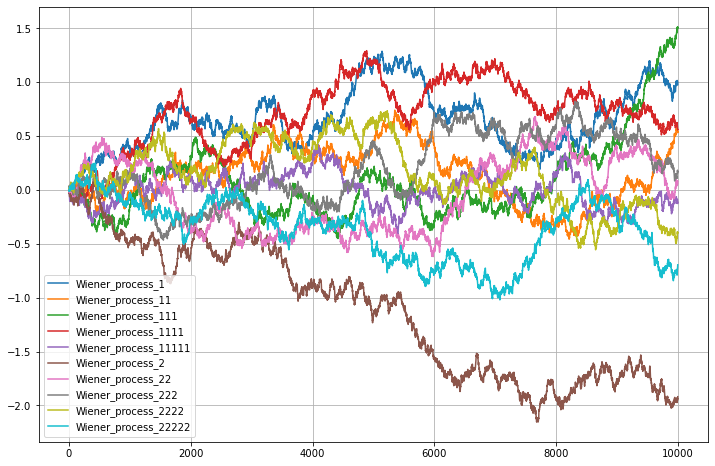

In [105]:
df = pd.DataFrame()
for i in [1, 11, 111, 1111, 11111, 2, 22, 222, 2222, 22222]:
    df['Wiener_process_' + str(i)] =  make_Wiener_simulation_easy(rnd=i)
df.to_csv('simulation_4.csv')
df.plot(grid= True, figsize= (12, 8))

In [103]:
def square_sum_easy(order = 10):
    summ = np.sum(np.diff(make_Wiener_simulation_easy(T=1, step = 2.0**(-order), rnd=42))**2)
    return summ

In [104]:
square_sum_easy()

0.9575113045734073

### Проверим, что свойство в задании 3.4 выполняется

#### Свойство:

Пусть есть двоичное разбиение отрезка $[0, 1]$: $t_m^n = m \cdot 2^{-n}$, $m = 0,1,2... 2^{n} $

Тогда
$S_n = \sum_{m=0}^{2^n - 1} (w(t_{m+1}^n) - w(t_{m}^n))^2 \rightarrow t $ п.н.  при $n \rightarrow \inf$

In [45]:
x_args = np.arange(0,19,2)
x_args

array([ 0,  2,  4,  6,  8, 10, 12, 14, 16, 18])

In [53]:
%%time
arr = []
for n in tqdm(x_args):
    tmp = square_sum(order = n)
    arr.append(tmp)
    #print(f"order = {n}\t Sn = {tmp}")

100%|██████████| 10/10 [05:00<00:00, 30.06s/it]

Wall time: 5min


In [54]:
arr2 = []
for n in tqdm(x_args):
    tmp = square_sum_comb(order = n)
    arr2.append(tmp)

  0%|          | 0/10 [00:00<?, ?it/s]<ipython-input-2-09fd761e572f>:13: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  integr = integrate.quad(lambda s: phi(s, i), 0, t, epsabs= 1e-4)[0]
 20%|██        | 2/10 [00:00<00:02,  2.94it/s]<ipython-input-2-09fd761e572f>:13: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  integr = integrate.quad(lambda s: phi(s, i), 0, t, epsabs= 1e-4)[0]
100%|██████████| 10/10 [22:22<00:00, 134.21s/it]


In [108]:
arr3 = []
for n in tqdm(x_args):
    tmp = square_sum_easy(order = n)
    arr3.append(tmp)

100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


In [115]:
print(arr, arr2, arr3, sep ='\n')

[0.0, 0.3339452504799873, 0.7172004748253943, 0.771133432791588, 0.7480280541968729, 0.2757519359197939, 0.07059829309858909, 0.017675959042657303, 0.004419402475855498, 0.00110485706806575]
[0.0, 0.3339452504800026, 0.7173178877201812, 0.748721969649949, 1.2118400600231054, 1.0880915537974105, 0.36274817668607195, 0.07318426742522917, 0.020881413731053195, 0.02068369196975816]
[0.24672494980166626, 0.751240588169321, 0.8846633150994769, 0.8289574346810116, 0.9489372724641887, 0.9575113045734073, 0.994194950784284, 1.006166594988117, 1.0038310217463808, 0.9997884750280159]


In [118]:
x_args

array([ 0,  2,  4,  6,  8, 10, 12, 14, 16, 18])

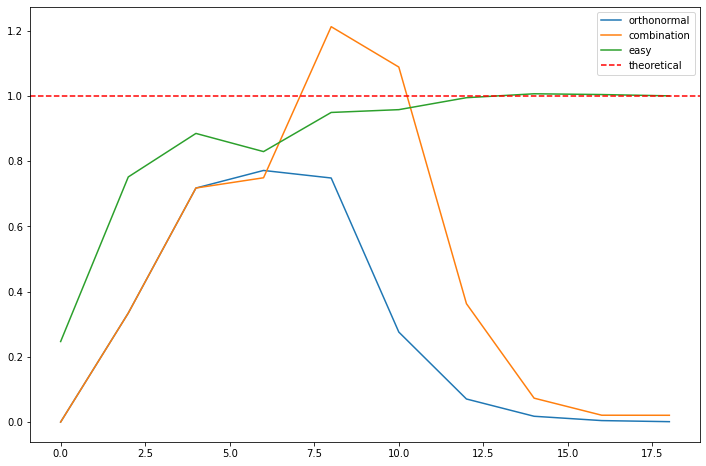

In [117]:
plt.plot(x_args, arr[:19], label='orthonormal')
plt.plot(x_args[:len(arr2)], arr2[:19], label='combination')
plt.plot(x_args, arr3[:19], label='easy')
plt.axhline(y=1, color='r', linestyle='--', label='theoretical')
plt.legend()

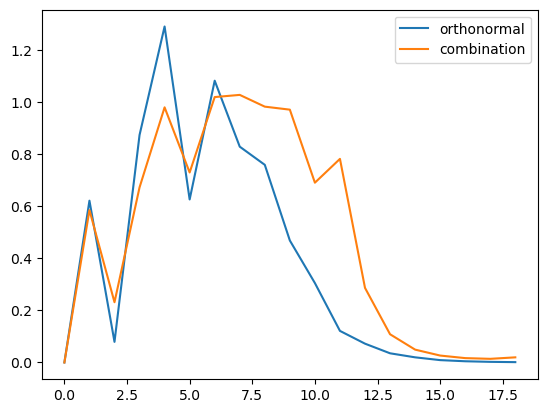

In [16]:
sns.lineplot(arr[:19], label='orthonormal')
sns.lineplot(arr2[:19], label='combination')
plt.legend()

###  Вывод к заданию 2.4


Из графиков для наивной симуляции следует сходимость к теоретическому значению.

При этом возникают явные ошибки при симуляции через ортнормированный базис и через комбинацию способов. Это может быть вызвано двойным предельным переходом (переход при суммировании для получения симуляции и предел для суммирования проверки свойства)


# Задача 2.5

Требуется вычислить интеграли Ито $\int_0^1 w(\omega, u)dw(\omega,u)$ и интеграл Стратоновича
$\int_0^1 w(\omega, u) \circ dw(\omega,u)$ с шагом разбиения $h=0.000001$

После этого требуется сравнить эти аппроксимации с теоритическими значениями $\frac{w^2(\omega,1) - 1}{2}$ и $\frac{w^2(\omega,1)}{2}$ соответственно

In [2]:
def ito_int(Wiener_process):
    return np.sum(np.diff(Wiener_process) * Wiener_process[1:])

def stratonovich_int(Wiener_process):
    tmp = (Wiener_process[:-1] + Wiener_process[1:])/2
    return np.sum(np.diff(Wiener_process) * tmp)

In [14]:
def calculate_ints(h = 0.000001, rnd = 42, sim_type = 'easy'):
    '''sim_type - how to make Wiener process
    easy - with make_Wiener_simulation_easy
    comb - make_Wiener_simulation_comb
    ortho - make_Wiener_simulation'''
    
    sim_dict = {'easy': make_Wiener_simulation_easy,
               'comb': make_Wiener_simulation_comb,
               'ortho': make_Wiener_simulation}
    if sim_type not in sim_dict.keys():
        raise Exception('ERROR: unknown sim_type' )
    np.random.seed(rnd)
    
    Wiener_process = np.array(sim_dict[sim_type](step = h, rnd = rnd))
    
    print(f'Calculated Ito`s integral: {ito_int(Wiener_process)}\t Theoretical: {(Wiener_process[-1]**2+1)/2}\n\n')
    
    print(f'Calculated Stratonovich`s integral: {stratonovich_int(Wiener_process)}\t Theoretical: {(Wiener_process[-1]**2)/2}\n\n')

    

In [15]:
calculate_ints(sim_type = 'easy')

Calculated Ito`s integral: 1.779799690561555	 Theoretical: 1.7796103564675476


Calculated Stratonovich`s integral: 1.2796103564675476	 Theoretical: 1.2796103564675476




In [82]:
calculate_ints(sim_type = 'comb')

<ipython-input-2-09fd761e572f>:13: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  integr = integrate.quad(lambda s: phi(s, i), 0, t, epsabs= 1e-4)[0]
<ipython-input-2-09fd761e572f>:13: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  integr = integrate.quad(lambda s: phi(s, i), 0, t, epsabs= 1e-4)[0]
100%|██████████| 999/999 [00:00<00:00, 4114.36it/s]


Calculated Ito`s integral: 0.15648118443111894	 Theoretical: 0.1233274658091851


Calculated Stratonovich`s integral: 0.12332696580918512	 Theoretical: 0.1233269658091851




In [85]:
calculate_ints(h = 0.00001, sim_type = 'ortho')

Calculated Ito`s integral: 0.10126826344065448	 Theoretical: 0.09982510849343314


Calculated Stratonovich`s integral: 0.09982010849343312	 Theoretical: 0.09982010849343313




### Выводы к задаче 2.5

Теоритеческая формула для интеграла Стратановича однозначно подтверждена

Для интеграла Ито получилось подтвердить формулу в случае симуляции через симуляцию путём прибавления приращений (наивная) $\int_0^1 w(\omega, u)dw(\omega,u) = \frac{w^2(\omega,1) + 1}{2}$,

Для других методов симуляции не получилось проверить теоретические факты, опять же проблема может быть в двойном пределельном переходе (для симуляции винеровского процесса и для вычисления интегралов)

In [95]:
# quick check for problem 2.3
N = 1000000
h = 1/ N

a = np.random.normal(loc=0, scale=h**0.5,size=N)
np.sum(a**2)

1.0003794359705467